Imputed MLP with Fairness Constraints

In [2]:
import pandas as pd
from train_eval_functions import *
import importlib
import joblib
from IPython.display import clear_output


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/zengsimon/miniconda3/envs/hrs/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/zengsimon/miniconda3/envs/hrs/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/zengsimon/miniconda3/envs/hrs/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  

In [3]:
#defining all load data scenarios
from sklearn.model_selection import train_test_split
from collections import defaultdict 

def check_if_better(current_sp, current_eo, current_max_gap, best_sp, best_eo, best_max_gap, tolerance=0.01):
    improved_sp = abs(current_sp) < abs(best_sp) - tolerance
    improved_eo = abs(current_eo) < abs(best_eo) - tolerance
    improved_max_gap = abs(current_max_gap) < abs(best_max_gap) - tolerance
    return improved_sp or improved_eo or improved_max_gap

def stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200):
    train_class_distribution = train_df['mortality_ten_years'].value_counts(normalize=True)
    rounded_distribution = (train_class_distribution * 100).round().astype(int)
    #print(rounded_distribution)
    #print(id_test_df['mortality_ten_years'].value_counts(normalize=True))
    #print(ood_test_df['mortality_ten_years'].value_counts(normalize=True))

    id_test_df = stratified_sample(id_test_df, target_col='mortality_ten_years', n_samples=n_samples, class_distribution=rounded_distribution)
    ood_test_df = stratified_sample(ood_test_df, target_col='mortality_ten_years', n_samples=n_samples, class_distribution=rounded_distribution)

    return train_df, id_test_df, ood_test_df

def fill_na_val(train_df, id_test_df, ood_test_df):
    train_df = train_df.fillna(-999)
    id_test_df = id_test_df.fillna(-999)
    ood_test_df = ood_test_df.fillna(-999)

    X_train, y_train = split_dataset_into_x_y(train_df, 'mortality_ten_years')
    X_id_test, y_id_test = split_dataset_into_x_y(id_test_df, 'mortality_ten_years')
    X_ood_test, y_ood_test = split_dataset_into_x_y(ood_test_df, 'mortality_ten_years')

    return X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test

def impute(train_df, id_test_df, ood_test_df):
    imp_norm_pipe = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="mean",missing_values=pd.NA)),
            ("normalizer", StandardScaler())])
    
    X_train, y_train = split_dataset_into_x_y(train_df, 'mortality_ten_years')
    X_id_test, y_id_test = split_dataset_into_x_y(id_test_df, 'mortality_ten_years')
    X_ood_test, y_ood_test = split_dataset_into_x_y(ood_test_df, 'mortality_ten_years')

    all_na_cols = X_train.columns[X_train.isna().all()]
    X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)  
    X_train = pd.DataFrame(imp_norm_pipe.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

    X_id_test = X_id_test.drop(columns=all_na_cols).fillna(np.nan)  
    X_id_test = pd.DataFrame(imp_norm_pipe.transform(X_id_test), columns=X_id_test.columns, index=X_id_test.index)

    X_ood_test = X_ood_test.drop(columns=all_na_cols).fillna(np.nan)  
    X_ood_test = pd.DataFrame(imp_norm_pipe.transform(X_ood_test), columns=X_ood_test.columns, index=X_ood_test.index)

    return X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test

def load_data_scenario_1(imputed=False):
    '''
    Train: 2006-2010
    ID Test: 2012
    OOD Test: 2014-2016
    '''

    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
    train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
    id_test_df = data_dict['2012']
    ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)

    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_2(imputed=False):
    '''
    Train: 2006-2008
    ID Test: 2010-2012
    OOD Test: 2014-2016
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
    train_df = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
    id_test_df = pd.concat([data_dict['2010'], data_dict['2012']], ignore_index=True)
    ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)
    
    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_3(imputed=False):
    '''
    Train: 2006-2010 (80%)
    ID Test: 2006-2010 (20%)
    OOD Test: 2016
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')

    dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
    X_dataset = dataset.drop(columns=["mortality_ten_years"])
    y_dataset = dataset["mortality_ten_years"]
    X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

    train_df = pd.concat([X_train, y_train], axis=1)
    id_test_df = pd.concat([X_id_test, y_id_test], axis=1)
    ood_test_df = data_dict['2016']

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_4(imputed=False):
    '''
    Train: 2006-2014 (80%) all regions except 11 1 2
    ID Test: 2006-2014 (20%) all regions except 11 1 2
    OOD Test: 2016. 11, 1, 2
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
    dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014']], ignore_index=True)

    dataset.drop(dataset[dataset['state_live_current'].isin([97, 98, 99, 11, 1, 2])].index, inplace=True)

    X_dataset = dataset.drop(columns=["mortality_ten_years"])
    y_dataset = dataset["mortality_ten_years"]

    X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

    train_df = pd.concat([X_train, y_train], axis=1)
    id_test_df = pd.concat([X_id_test, y_id_test], axis=1)
    ood_test_df = data_dict['2016']
    ood_test_df.drop(ood_test_df[~ood_test_df['state_live_current'].isin([11, 1, 2])].index, inplace=True)

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_5(imputed=False):
    '''
    Train: 2006-2016 (80%) regions 3, 4, 5, 6
    ID Test: 2006-2016 (20%) regions 3, 4, 5, 6
    OOD Test: 2006-2016 region 1
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')

    dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014'], data_dict['2016']], ignore_index=True)
    dataset.drop(dataset[dataset['race'].isin([-999, 8, 9, 2, 7])].index, inplace=True)

    X_dataset = dataset.drop(columns=["mortality_ten_years"])
    y_dataset = dataset["mortality_ten_years"]

    X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

    train_df = pd.concat([X_train, y_train], axis=1)
    id_test_df = pd.concat([X_id_test, y_id_test], axis=1)
    ood_test_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014'], data_dict['2016']], ignore_index=True)
    ood_test_df.drop(ood_test_df[~ood_test_df['state_live_current'].isin([1])].index, inplace=True)

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_6(imputed=False):
    '''
    Train: 2006-2010 (80%)
    ID Test: 2010-2012 (20%)
    OOD Test: 2014-2016
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')

    dataset = data_dict['2010']
    X_dataset = dataset.drop(columns=["mortality_ten_years"])
    y_dataset = dataset["mortality_ten_years"]

    X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

    dataset = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
    X_train = pd.concat([dataset.drop(columns=["mortality_ten_years"]), X_train])
    y_train = pd.concat([dataset["mortality_ten_years"], y_train])

    id_test_df = data_dict['2012']
    X_id_test = pd.concat([id_test_df, X_id_test])
    y_id_test = pd.concat([id_test_df["mortality_ten_years"], y_id_test])

    train_df = pd.concat([X_train, y_train], axis=1)
    id_test_df = pd.concat([X_id_test.drop(columns=["mortality_ten_years"]), y_id_test], axis=1)
    ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
import numpy as np

class WeightedMLPClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=200, learning_rate_init=0.0007,random_state=None):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.max_iter = max_iter
        self.random_state = random_state
        self.learning_rate_init = learning_rate_init
        self.model = MLPClassifier(
            hidden_layer_sizes=self.hidden_layer_sizes,
            activation=self.activation,
            solver=self.solver,
            max_iter=self.max_iter,
            random_state=self.random_state,
            warm_start=True,
            learning_rate_init=self.learning_rate_init
        )

    def fit(self, X, y, sample_weight=None):
        feature_names = None
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()

        if sample_weight is not None:
            sample_weight = np.asarray(sample_weight)
            indices = np.arange(len(y))
            repeated_indices = np.repeat(indices, sample_weight.astype(int))
            X = X[repeated_indices]
            y = y[repeated_indices]

        self.model.fit(X, y)
        return self

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return self.model.predict(X)

    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return self.model.predict_proba(X)

    def decision_function(self, X):
        return self.model.predict_proba(X)[:, 1]  # For binary classification



In [ ]:
def train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test):
    best_sp, best_eo, best_max_gap = float('inf'), float('inf'), float('inf')
    no_improvement_count = 0
    patience = 3  #number of evaluation steps to wait for improvement
    tolerance = 0.015  # minimum improvement required for each metric

    #X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_1(imputed=True)
    #EXP_GRAD_SENS_ATTR = "race"
    clf = WeightedMLPClassifier(hidden_layer_sizes=(200,100,50), learning_rate_init=0.005,
                                   max_iter=50, random_state=42)
    objective = ErrorRate(costs={'fp': 0.5, 'fn': 0.5})
    #constraint = DemographicParity(difference_bound=0.05) # can be changed to other constraints instead 
    #constraint = EqualizedOdds(difference_bound=0.05)

    ITERATIONS = 5
    EVAL_EVERY = 1

    mitigator = ExponentiatedGradient(clf, constraint, objective=objective, max_iter=ITERATIONS)
    metrics_history = defaultdict(list)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        mitigator.fit(X_train, y_train, sensitive_features=X_train[EXP_GRAD_SENS_ATTR])
        predictors = mitigator.predictors_ 
        weights = mitigator.weights_ 

        for i in range(1, ITERATIONS+1): 
            combined_proba = np.zeros((X_train.shape[0], 2)) 
            for j in range(min(i, len(predictors))):  # Ensure loop doesn't exceed predictor count
                if j >= len(weights):
                    print(f"Skipping iteration {j}, weight not available")
                    continue
                combined_proba += weights[j] * predictors[j].predict_proba(X_train)


            y_train_pred = np.argmax(combined_proba, axis=1)
            acc = accuracy_score(y_train, y_train_pred)
            metrics_history["accuracy"].append(acc)

            if i % EVAL_EVERY == 0:
                sp, eo, max_gap = get_fairness_metrics(
                    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
                    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=True, expo_grad=True
                )
                metrics_history["sp"].append(sp[EXP_GRAD_SENS_ATTR][0])
                metrics_history["eo"].append(eo[EXP_GRAD_SENS_ATTR][0])
                metrics_history["max_gap"].append(max_gap[EXP_GRAD_SENS_ATTR][0])

                if check_if_better(sp[EXP_GRAD_SENS_ATTR][0], eo[EXP_GRAD_SENS_ATTR][0], max_gap[EXP_GRAD_SENS_ATTR][0], best_sp, best_eo, best_max_gap, tolerance=tolerance):
                    # Update best metrics
                    best_sp, best_eo, best_max_gap = sp[EXP_GRAD_SENS_ATTR][0], eo[EXP_GRAD_SENS_ATTR][0], max_gap[EXP_GRAD_SENS_ATTR][0]
                    no_improvement_count = 0
                    print("Fairness metrics improved, continuing...")
                else:
                    no_improvement_count += 1
                    print(f"No improvement in fairness metrics for {no_improvement_count} evaluations.")

                # Stop early if no improvement for `patience` evaluations
                if no_improvement_count >= patience:
                    print("Early stopping: No significant improvement in fairness metrics.")
                    break

    evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test) #save_as=f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/{save_paths[idx]}_eval.txt")

    iterations = range(1, len(metrics_history["accuracy"]) + 1)
    eval_iterations = range(1, len(metrics_history["sp"]) + 1)
    eval_iterations = [i * EVAL_EVERY for i in eval_iterations]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].plot(iterations, metrics_history["accuracy"], marker='o', label="Accuracy", color="blue")
    axes[0, 0].set_title("Accuracy Over Iterations")
    axes[0, 0].set_xlabel("Iteration")
    axes[0, 0].set_ylabel("Accuracy")
    axes[0, 0].grid(True)

    axes[0, 1].plot(eval_iterations, metrics_history["sp"], marker='o', label="Statistical Parity", color="green")
    axes[0, 1].set_title("Statistical Parity Difference Over Iterations")
    axes[0, 1].set_xlabel("Iteration")
    axes[0, 1].set_ylabel("Statistical Parity Difference")
    axes[0, 1].grid(True)

    axes[1, 0].plot(eval_iterations, metrics_history["eo"], marker='o', label="Equalized Odds", color="orange")
    axes[1, 0].set_title("Equalized Odds Difference Over Iterations")
    axes[1, 0].set_xlabel("Iteration")
    axes[1, 0].set_ylabel("Equalized Odds Difference")
    axes[1, 0].grid(True)

    axes[1, 1].plot(eval_iterations, metrics_history["max_gap"], marker='o', label="Max Calibration Gap", color="red")
    axes[1, 1].set_title("Max Calibration Gap Over Iterations")
    axes[1, 1].set_xlabel("Iteration")
    axes[1, 1].set_ylabel("Max Calibration Gap")
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return mitigator
    


In [54]:
all_was_dist = []
all_sp = []
all_eo = []
all_max_gap = []

EXP_GRAD_SENS_ATTR = "state_live_current"

Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
ID Test Results: 
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       126
           1       0.52      0.50      0.51        74

    accuracy                           0.65       200
   macro avg       0.62      0.62      0.62       200
weighted avg       0.64      0.65      0.64       200

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.64      0.67      0.65       126
           1       0.38      0.35      0.37        74

    accuracy                           0.55       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.54      0.55      0.55       200



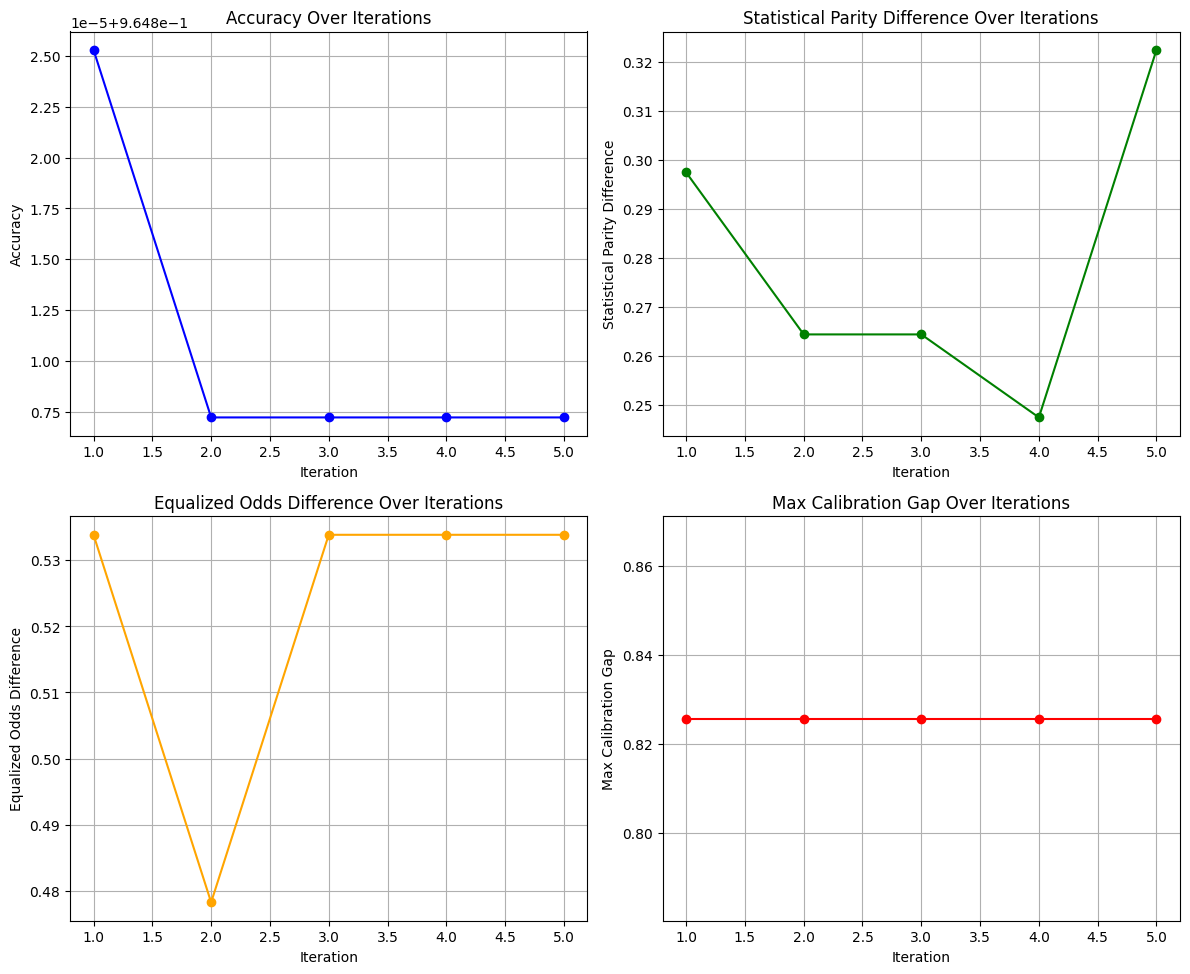

state_live_current:

Statistical Parity Difference (Train): 0.2385183160196829
Equalized Odds Difference (Train): 0.4227053140096618
Max Calibration Gap (Train): 0.8257222029379169

Statistical Parity Difference (ID Test): 0.3928571428571429
Equalized Odds Difference (ID Test): 0.75
Max Calibration Gap (ID Test): 0.9689583869194303

Statistical Parity Difference (OOD Test): 0.7894736842105263
Equalized Odds Difference (OOD Test): 1.0
Max Calibration Gap (OOD Test): 0.9663304124594297

running again


In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_1(imputed=True)

constraint = DemographicParity(difference_bound=0.2) # can be changed to other constraints instead 
#constraint = EqualizedOdds(difference_bound=0.05)

mitigator = train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test)

sp, eo, max_gap = get_fairness_metrics(
    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=False, expo_grad=True
)

In [57]:
evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_1_eval.txt")
joblib.dump(mitigator, f"./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_mlp_1_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
all_sp.append(sp)
all_eo.append(eo)
all_max_gap.append(max_gap)

wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
all_was_dist.append(wd)

Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
No improvement in fairness metrics for 2 evaluations.
Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
ID Test Results: 
              precision    recall  f1-score   support

           0       0.64      0.67      0.65       115
           1       0.51      0.48      0.49        84

    accuracy                           0.59       199
   macro avg       0.57      0.57      0.57       199
weighted avg       0.58      0.59      0.59       199

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       115
           1       0.51      0.42      0.46        84

    accuracy                           0.59       199
   macro avg       0.57      0.56      0.56       199
weighted avg       0.58      0.59      0.58       199



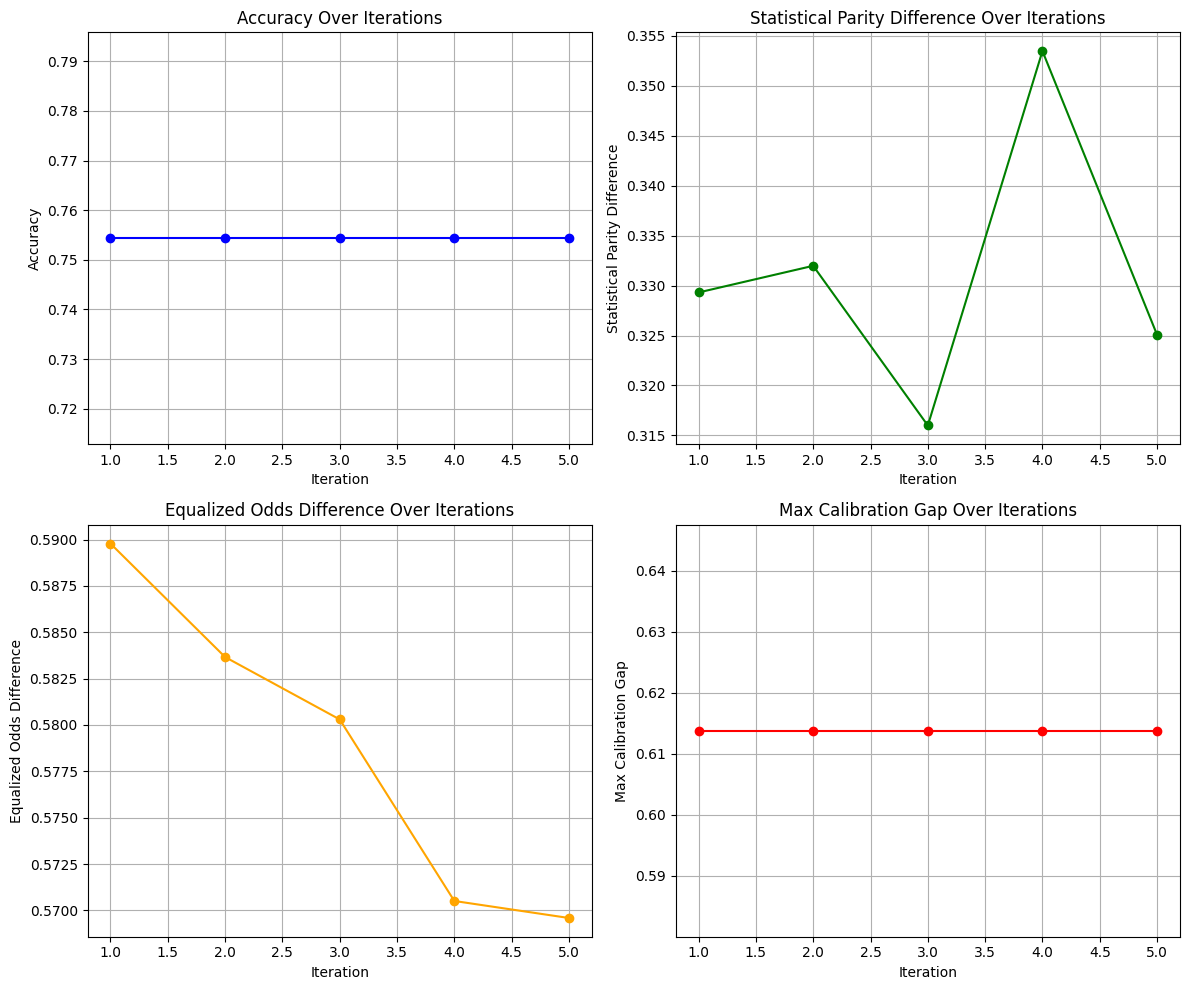

state_live_current:

Statistical Parity Difference (Train): 0.3422405026512675
Equalized Odds Difference (Train): 0.585806056898134
Max Calibration Gap (Train): 0.6137742212189823

Statistical Parity Difference (ID Test): 0.39999999999999997
Equalized Odds Difference (ID Test): 0.6153846153846154
Max Calibration Gap (ID Test): 0.8994116428870247

Statistical Parity Difference (OOD Test): 0.75
Equalized Odds Difference (OOD Test): 0.7142857142857143
Max Calibration Gap (OOD Test): 0.8840479048825219



In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_1(imputed=True)

constraint = DemographicParity(difference_bound=0.2) # can be changed to other constraints instead 
#constraint = EqualizedOdds(difference_bound=0.05)

mitigator = train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test)

sp, eo, max_gap = get_fairness_metrics(
    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=False, expo_grad=True
)

In [60]:
evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_2_eval.txt")
joblib.dump(mitigator, f"./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_mlp_2_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
all_sp.append(sp)
all_eo.append(eo)
all_max_gap.append(max_gap)

wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
all_was_dist.append(wd)

Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
No improvement in fairness metrics for 2 evaluations.
No improvement in fairness metrics for 3 evaluations.
Early stopping: No significant improvement in fairness metrics.
ID Test Results: 
              precision    recall  f1-score   support

           0       0.74      0.71      0.73       126
           1       0.54      0.57      0.55        74

    accuracy                           0.66       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.66      0.66      0.66       200

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.62      0.71      0.66       126
           1       0.35      0.27      0.31        74

    accuracy                           0.55       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.52      0.55      0.53       200



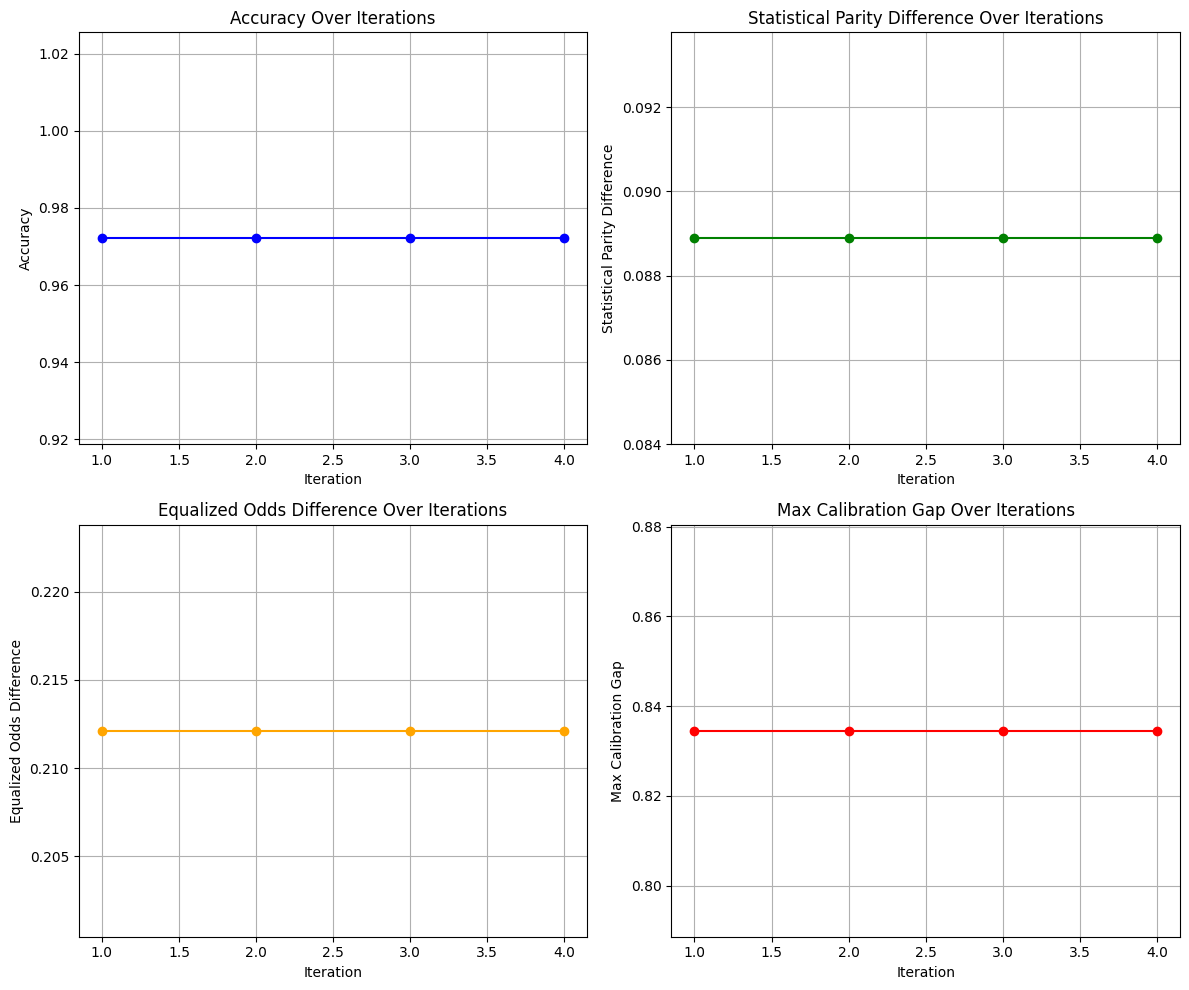

state_live_current:

Statistical Parity Difference (Train): 0.0888888888888889
Equalized Odds Difference (Train): 0.21212121212121213
Max Calibration Gap (Train): 0.8345118421315204

Statistical Parity Difference (ID Test): 0.23412698412698413
Equalized Odds Difference (ID Test): 0.6
Max Calibration Gap (ID Test): 0.8968207328412817

Statistical Parity Difference (OOD Test): 0.8888888888888888
Equalized Odds Difference (OOD Test): 1.0
Max Calibration Gap (OOD Test): 0.9536552776020208



In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_1(imputed=True)

constraint = DemographicParity(difference_bound=0.2) # can be changed to other constraints instead 
#constraint = EqualizedOdds(difference_bound=0.05)

mitigator = train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test)

sp, eo, max_gap = get_fairness_metrics(
    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=False, expo_grad=True
)

In [63]:
evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_3_eval.txt")
joblib.dump(mitigator, f"./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_mlp_3_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
all_sp.append(sp)
all_eo.append(eo)
all_max_gap.append(max_gap)

wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
all_was_dist.append(wd)

Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
No improvement in fairness metrics for 2 evaluations.
No improvement in fairness metrics for 3 evaluations.
Early stopping: No significant improvement in fairness metrics.
ID Test Results: 
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       140
           1       0.56      0.53      0.55        60

    accuracy                           0.73       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.73      0.73      0.73       200

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.69      0.85      0.76       140
           1       0.25      0.12      0.16        60

    accuracy                           0.63       200
   macro avg       0.47      0.48      0.46       200
weighted avg       0.56      0.63      0.58       200



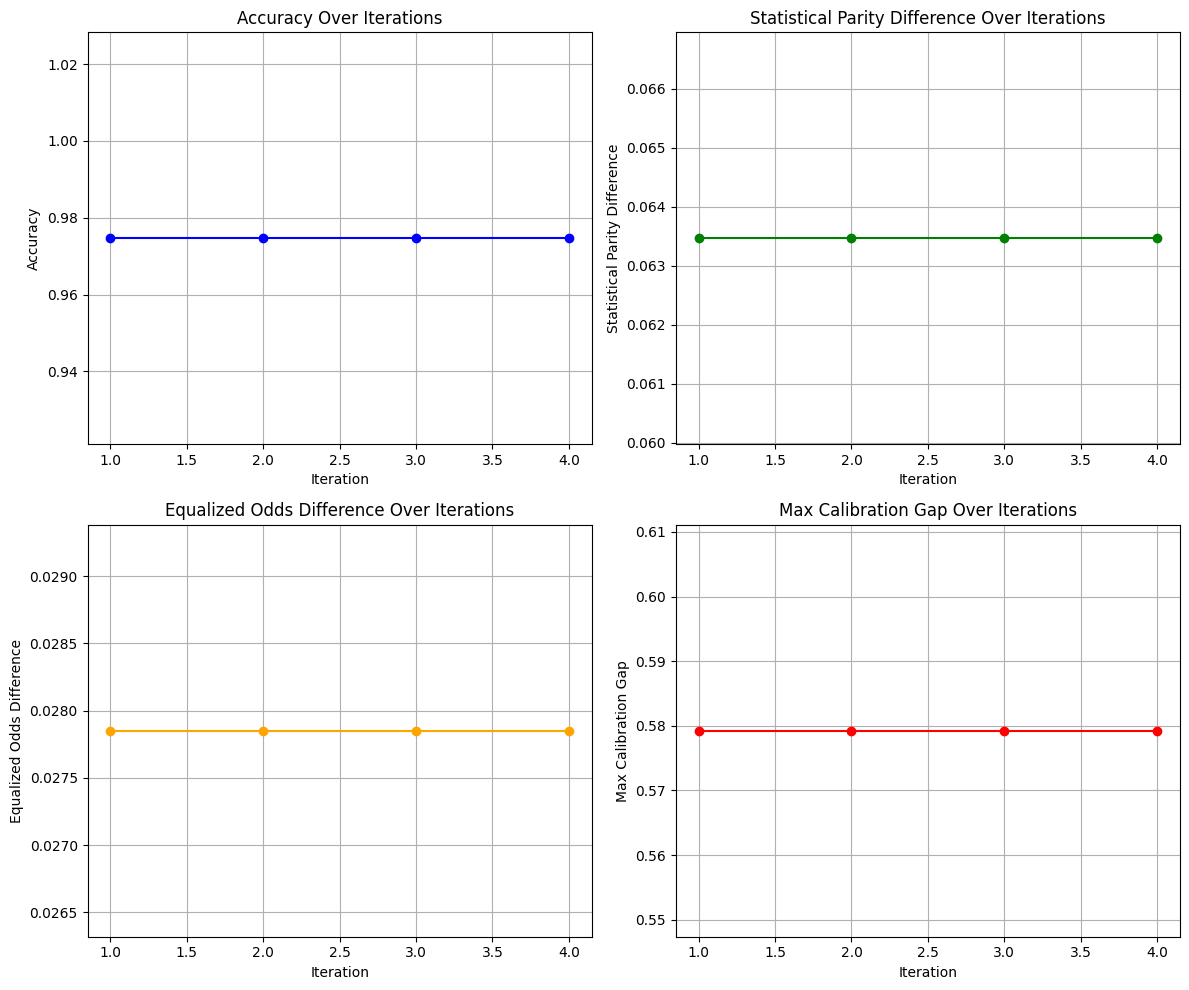

state_live_current:

Statistical Parity Difference (Train): 0.06346899224806202
Equalized Odds Difference (Train): 0.027849873009399156
Max Calibration Gap (Train): 0.5792379286786149

Statistical Parity Difference (ID Test): 0.2742175856929955
Equalized Odds Difference (ID Test): 0.7857142857142857
Max Calibration Gap (ID Test): 0.8268444076194026

Statistical Parity Difference (OOD Test): 0.07843137254901959
Equalized Odds Difference (OOD Test): 0.33333333333333337
Max Calibration Gap (OOD Test): 0.9620722017708561



In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_4(imputed=True)

constraint = DemographicParity(difference_bound=0.2) # can be changed to other constraints instead 
#constraint = EqualizedOdds(difference_bound=0.05)

mitigator = train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test)

sp, eo, max_gap = get_fairness_metrics(
    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=False, expo_grad=True
)

In [66]:
evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_4_eval.txt")
joblib.dump(mitigator, f"./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_mlp_4_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
all_sp.append(sp)
all_eo.append(eo)
all_max_gap.append(max_gap)

wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
all_was_dist.append(wd)

Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
ID Test Results: 
              precision    recall  f1-score   support

           0       0.74      0.62      0.68       146
           1       0.29      0.41      0.34        54

    accuracy                           0.56       200
   macro avg       0.51      0.52      0.51       200
weighted avg       0.62      0.56      0.58       200

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.76      0.53      0.63       146
           1       0.30      0.54      0.38        54

    accuracy                           0.54       200
   macro avg       0.53      0.54      0.51       200
weighted avg       0.63      0.54      0.56       200



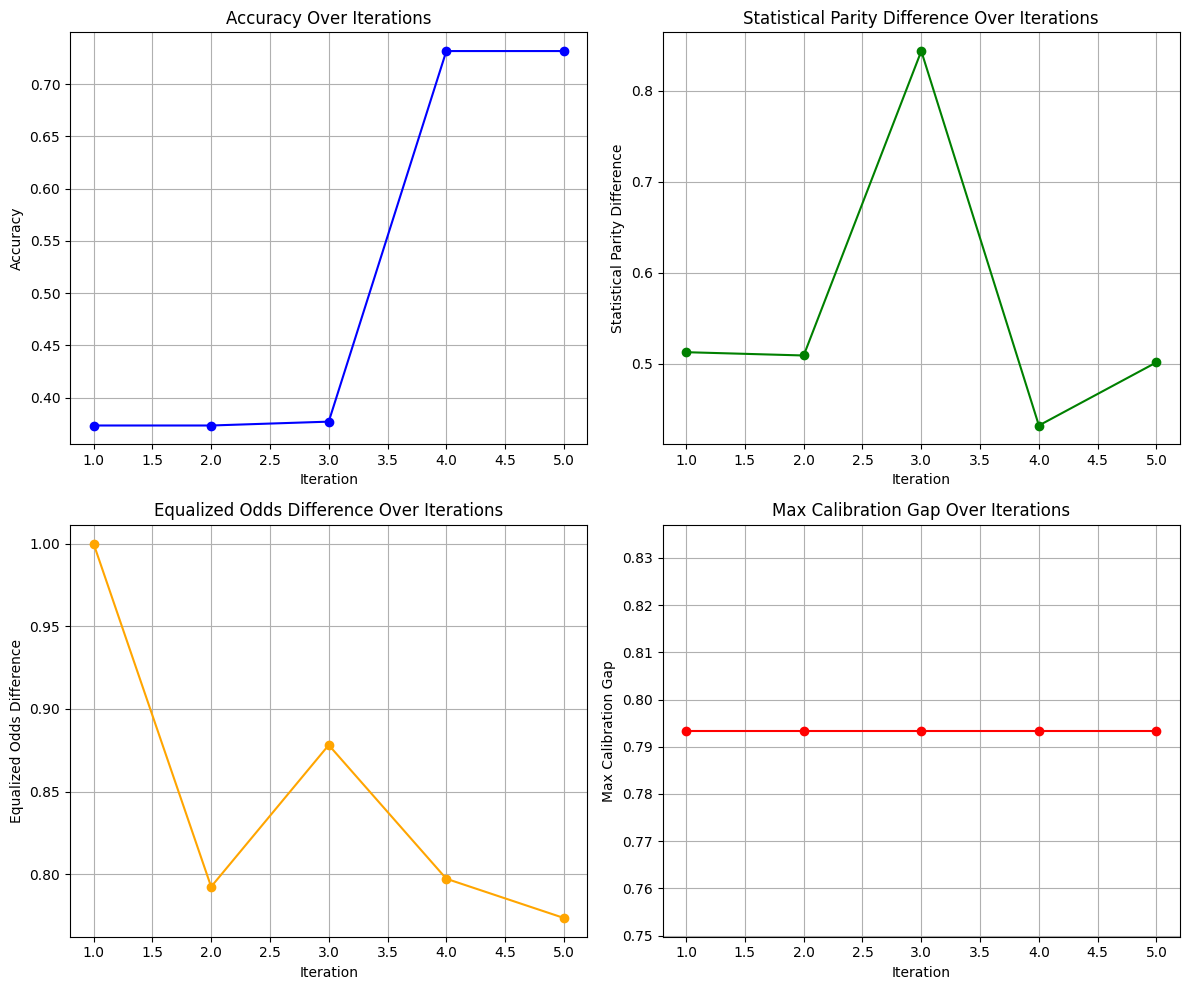

state_live_current:

Statistical Parity Difference (Train): 0.8493134879427714
Equalized Odds Difference (Train): 1.0
Max Calibration Gap (Train): 0.7933826356436126

Statistical Parity Difference (ID Test): 0.5
Equalized Odds Difference (ID Test): 1.0
Max Calibration Gap (ID Test): 0.9191694646962458

Statistical Parity Difference (OOD Test): 0.0
Equalized Odds Difference (OOD Test): 0.0
Max Calibration Gap (OOD Test): 0.18548507428578365

running again


In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_5(imputed=True)

constraint = DemographicParity(difference_bound=0.2) # can be changed to other constraints instead 
#constraint = EqualizedOdds(difference_bound=0.05)

mitigator = train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test)

sp, eo, max_gap = get_fairness_metrics(
    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=False, expo_grad=True
)

In [69]:
evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_5_eval.txt")
joblib.dump(mitigator, f"./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_mlp_5_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
all_sp.append(sp)
all_eo.append(eo)
all_max_gap.append(max_gap)

wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
all_was_dist.append(wd)

Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
No improvement in fairness metrics for 2 evaluations.
No improvement in fairness metrics for 3 evaluations.
Early stopping: No significant improvement in fairness metrics.
ID Test Results: 
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       124
           1       0.57      0.51      0.54        76

    accuracy                           0.67       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.66      0.67      0.66       200

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       124
           1       0.50      0.34      0.41        76

    accuracy                           0.62       200
   macro avg       0.58      0.57      0.56       200
weighted avg       0.60      0.62      0.60       200



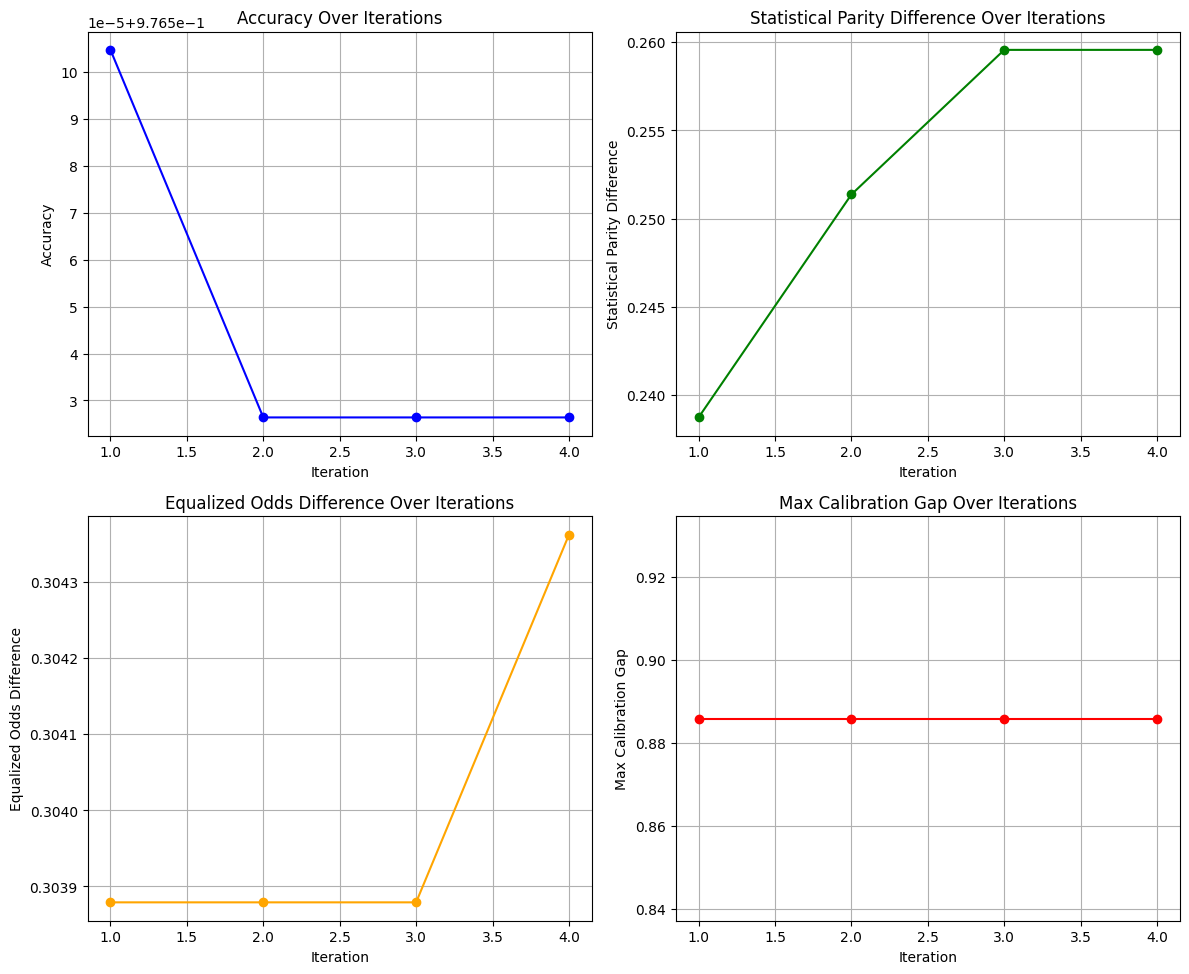

state_live_current:

Statistical Parity Difference (Train): 0.2513661202185793
Equalized Odds Difference (Train): 0.30387896346370513
Max Calibration Gap (Train): 0.8858308044960612

Statistical Parity Difference (ID Test): 0.4305555555555555
Equalized Odds Difference (ID Test): 0.75
Max Calibration Gap (ID Test): 0.8722123903035588

Statistical Parity Difference (OOD Test): 0.625
Equalized Odds Difference (OOD Test): 0.8333333333333334
Max Calibration Gap (OOD Test): 0.9999999534867279

running again


In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_6(imputed=True)

constraint = DemographicParity(difference_bound=0.2) # can be changed to other constraints instead 
#constraint = EqualizedOdds(difference_bound=0.05)

mitigator = train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test)

sp, eo, max_gap = get_fairness_metrics(
    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=False, expo_grad=True
)

In [72]:
evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_6_eval.txt")
joblib.dump(mitigator, f"./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_mlp_6_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
all_sp.append(sp)
all_eo.append(eo)
all_max_gap.append(max_gap)

wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
all_was_dist.append(wd)

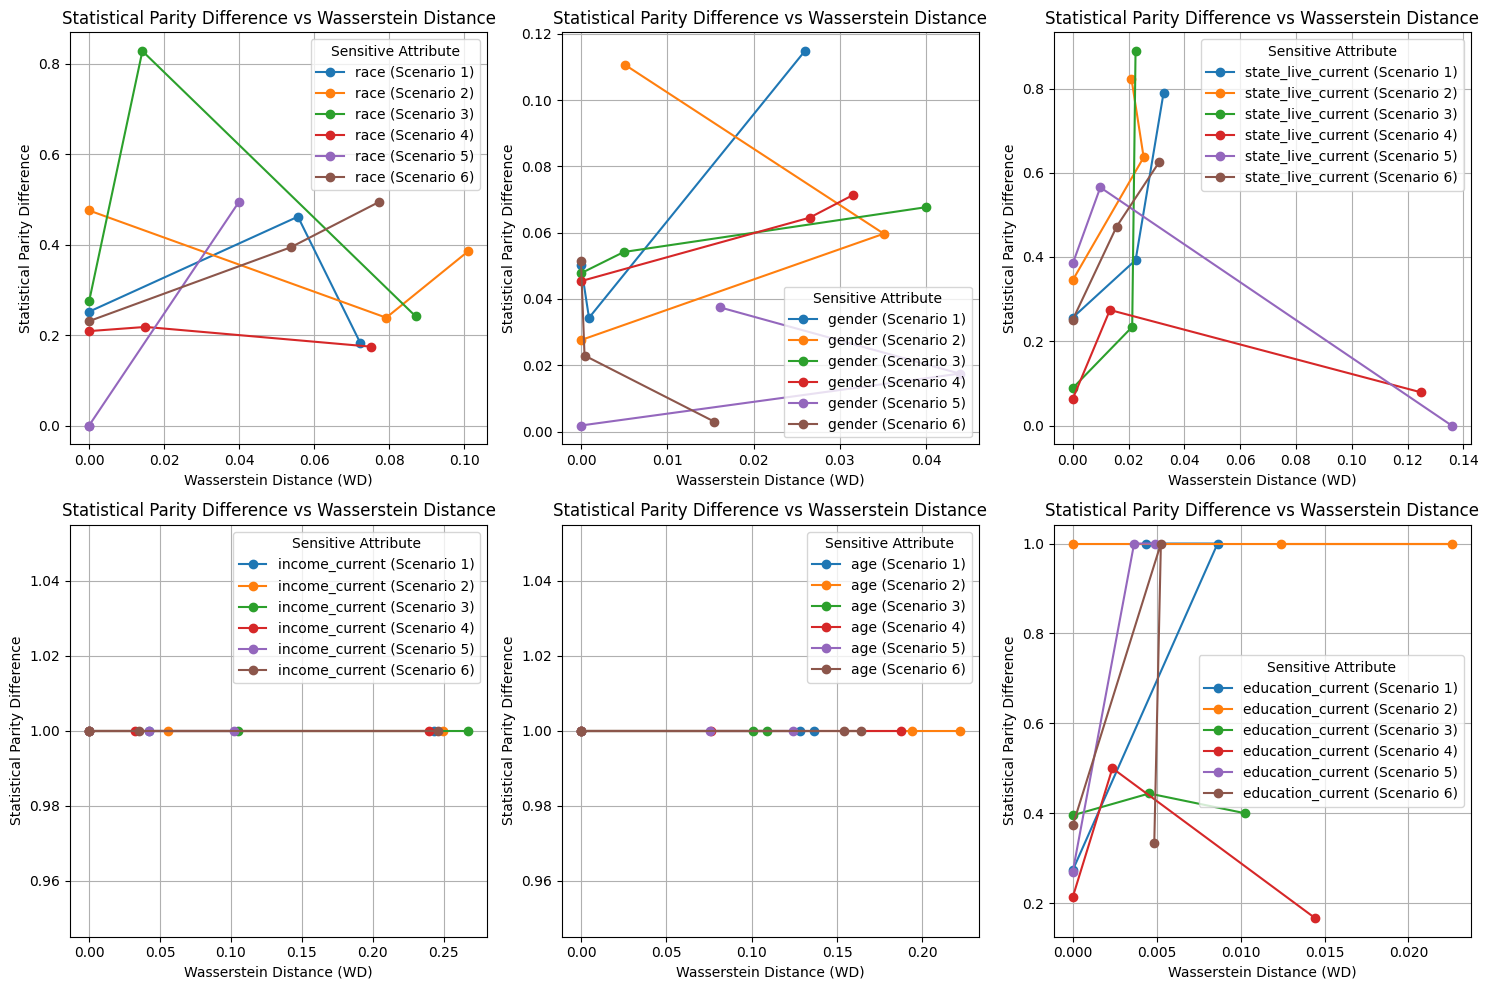

In [ ]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10)) 

for i, ax in enumerate(axes.flat): 
    attribute = protected_attributes[i]
    for x in range(len(all_sp)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_sp[x][attribute]
        #y_values = [y - y_raw[0] for y in y_raw]
        #ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        y_values = y_raw
        ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    ax.set_title(f"Statistical Parity Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Statistical Parity Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

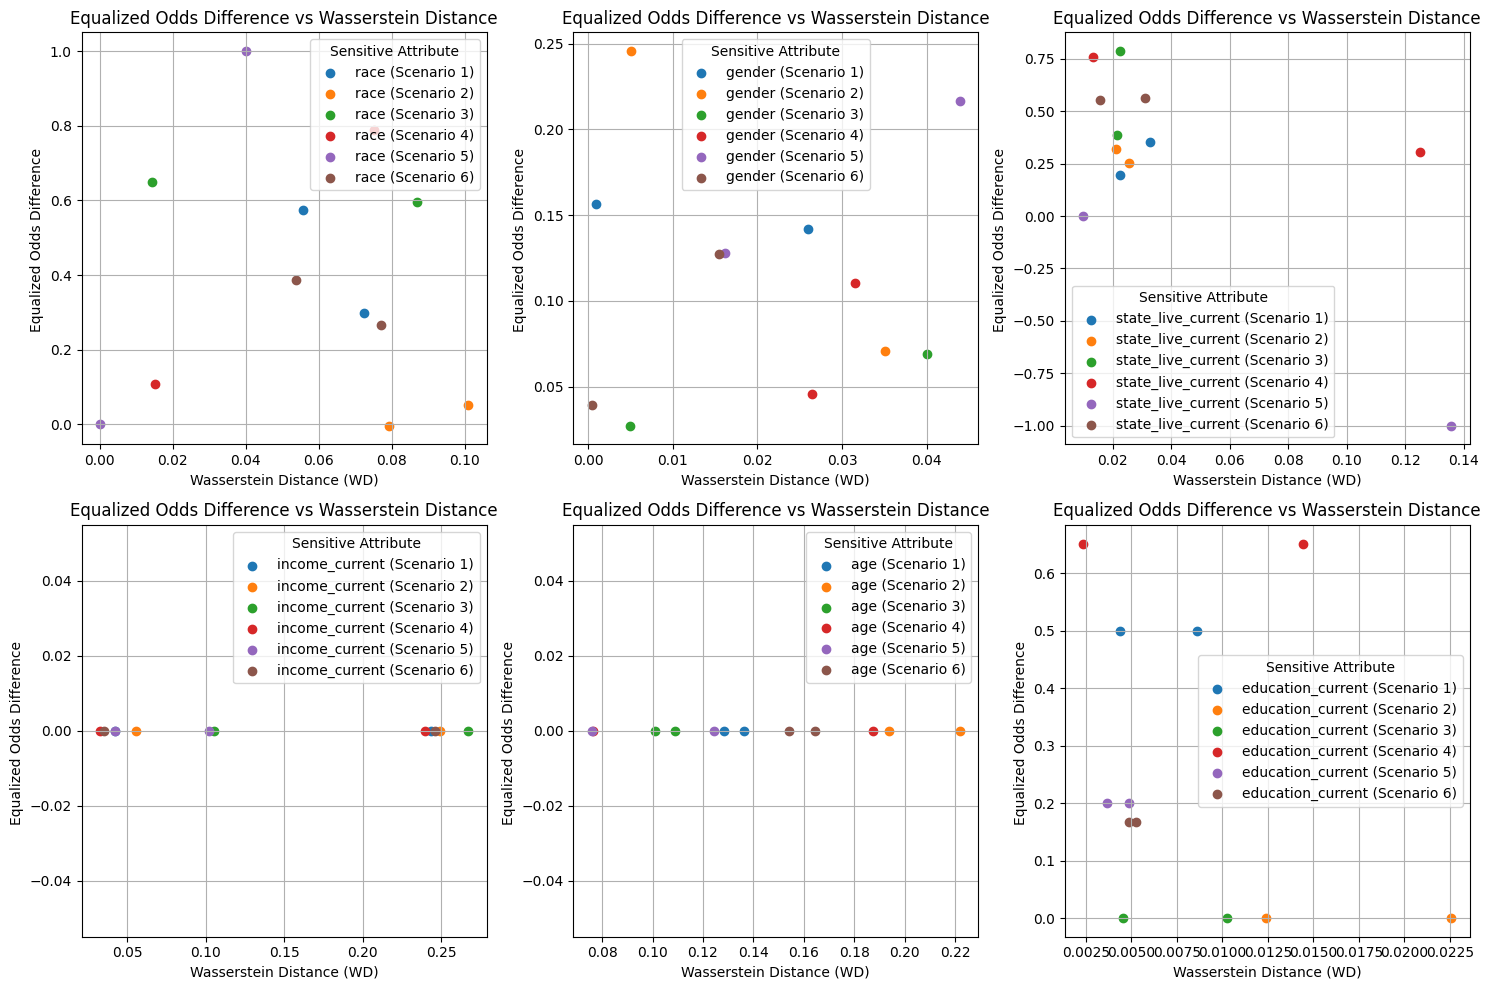

In [ ]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10)) 

for i, ax in enumerate(axes.flat): 
    attribute = protected_attributes[i]
    for x in range(len(all_eo)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_eo[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    ax.set_title(f"Equalized Odds Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Equalized Odds Difference ")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

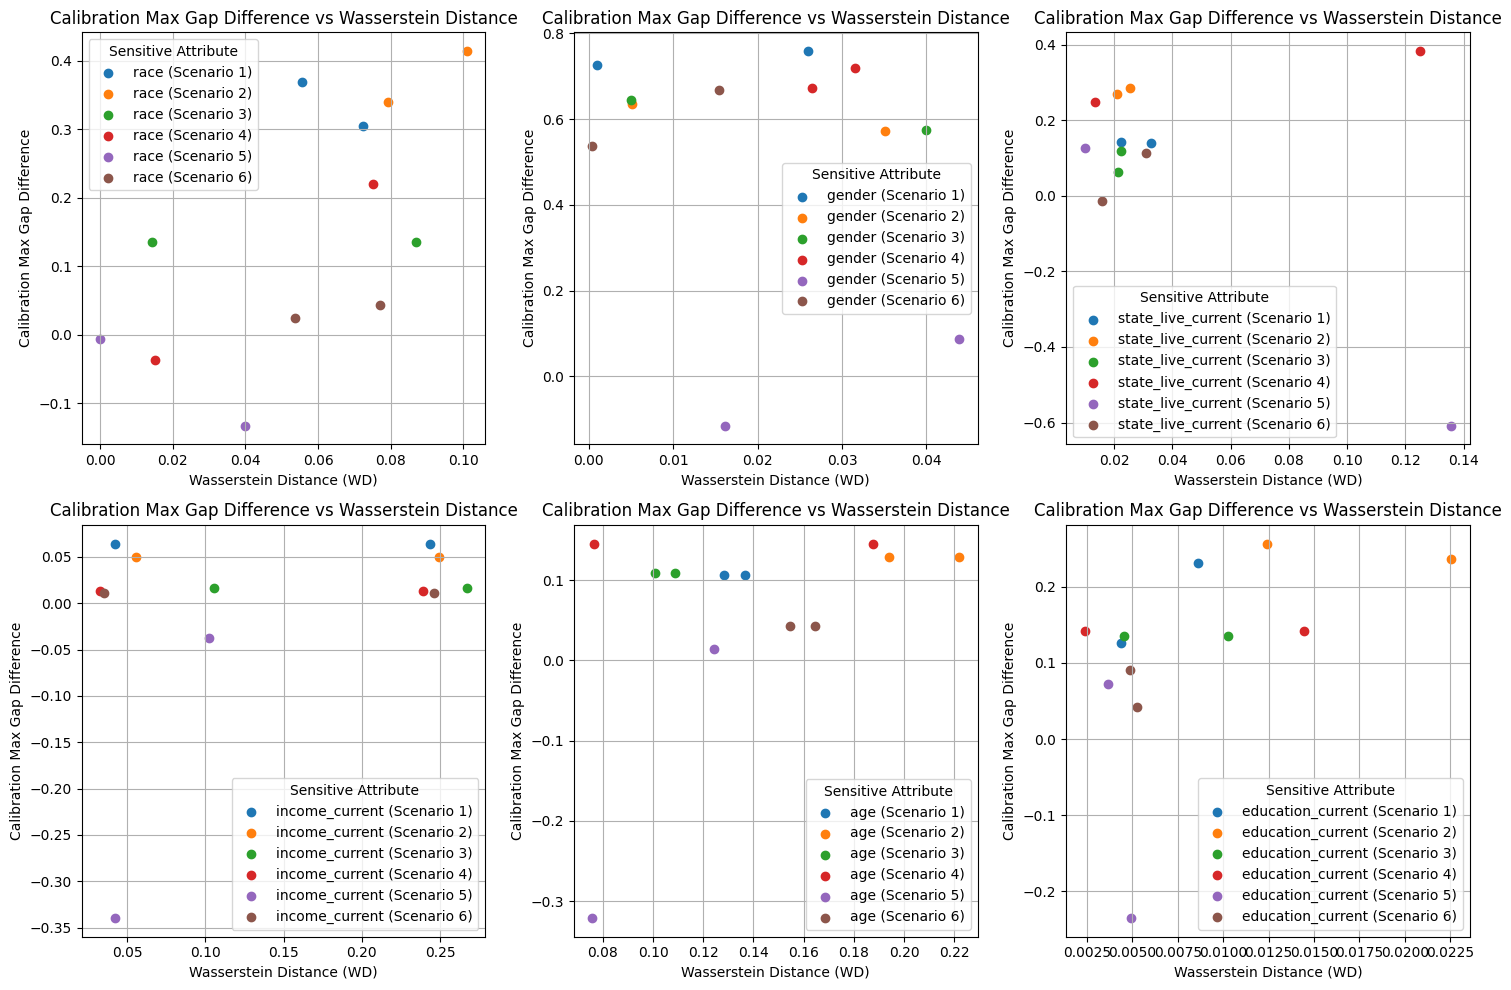

In [ ]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat): 
    attribute = protected_attributes[i]
    for x in range(len(all_max_gap)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_max_gap[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    ax.set_title(f"Calibration Max Gap Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Calibration Max Gap Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [76]:
#save

import pickle

with open(f'./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_gradient_imputed_mlp_was_dist.pkl', 'wb') as file:
    pickle.dump(all_was_dist, file)

with open(f'./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_gradient_imputed_mlp_sp.pkl', 'wb') as file:
    pickle.dump(all_sp, file)

with open(f'./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_gradient_imputed_mlp_eo.pkl', 'wb') as file:
    pickle.dump(all_eo, file)

with open(f'./exponentiated_gradient_imputed_mlp/{EXP_GRAD_SENS_ATTR}/exponentiated_gradient_imputed_mlp_max_gap.pkl', 'wb') as file:
    pickle.dump(all_max_gap, file)